## EMMA step 2: Projecting streamwater samples and potential endmembers into PCA space to select endmembers for EMMA
### -  Tracers selected in EMMA step 1: bivariate plots to ID conservative mixing

###  - MED note that my ealier python code had a mistake in that separate PCAs were performed on the streamwater and EM datasets. We want the same coordinate system to determine their relationships, so this code rectifies that issue.

### - Dynamic read-in: to use this notebook, change the 'site' parameter to "Wade" or "Hugnerford". Tracers and sample filtering will then occur as needed.

/tmp/ipykernel_16823/277900458.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streamwater_data["Date"] = pd.to_datetime(streamwater_data["Date"], format="%m/%d/%Y", errors="coerce")
/tmp/ipykernel_16823/277900458.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  endmember_data["Date"] = pd.to_datetime(endmember_data["Date"], format="%m/%d/%Y", errors="coerce")


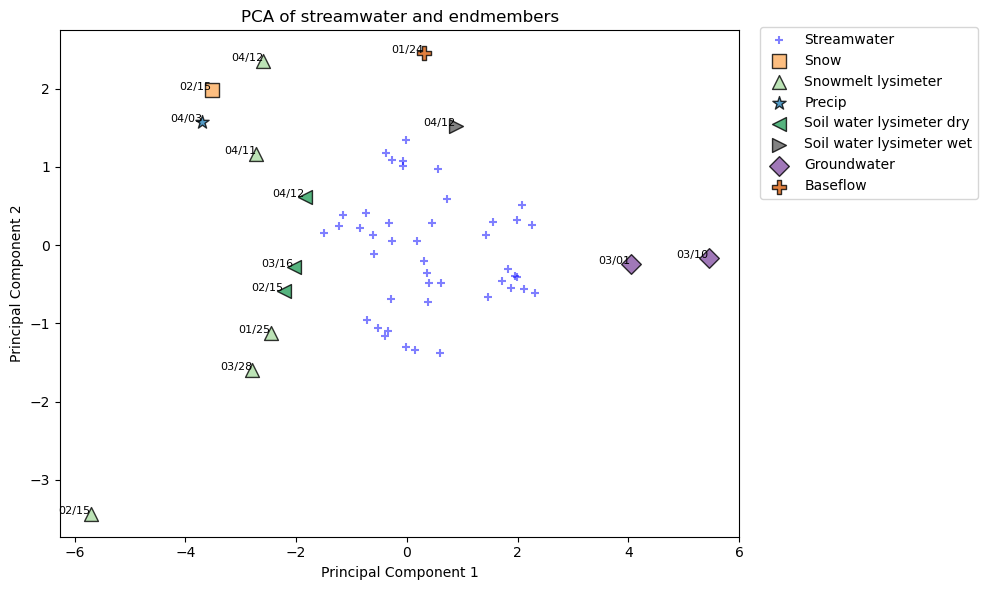

In [1]:
#####################################
# PCA of streamwater and EMs ########
# Megan E Duffy 06/21/2025 ##########
# Part of EMMA workflow #############
# MAKE SURE TO ADJUST site variable #
#####################################

# Set working directory
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set the site you want to work on
# This will be extracted from the entire dataset
site = "Wade"
#site = "Hungerford"

# This will modify the selected_parameters in filtering before scaling and PCA
if site == "Wade":
    tracers = ['Ca_mg_L', 'Si_mg_L','Mg_mg_L', 'dD', 'd18O']
if site == "Hungerford":
    tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L', 'dD', 'd18O']

# Load the data
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")

# Filter streamwater and endmember data
streamwater_data = data.loc[
    (data['Site'] == site) &
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

endmember_data = data.loc[
    (data['Site'] == site) &
    (data['Type'].isin(['Snow', 'Rain', 'Baseflow', 'Groundwater', 
                        'Soil water lysimeter dry', 'Soil water lysimeter wet', 
                        'Snowmelt lysimeter', 'Precip']))
]

# Convert date columns
streamwater_data["Date"] = pd.to_datetime(streamwater_data["Date"], format="%m/%d/%Y", errors="coerce")
endmember_data["Date"] = pd.to_datetime(endmember_data["Date"], format="%m/%d/%Y", errors="coerce")

# Selected tracers
# Based on site variable (see above)
selected_parameters = tracers

# Clean and tag data
subset_streamwater = streamwater_data[selected_parameters].dropna().copy()
subset_streamwater["Group"] = "Streamwater"
subset_streamwater["Type"] = "Streamwater"
subset_streamwater["Date"] = streamwater_data["Date"]

subset_endmembers = endmember_data[selected_parameters].copy()
subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())  # Simple impute
subset_endmembers["Group"] = "Endmember"
subset_endmembers["Type"] = endmember_data["Type"].values
subset_endmembers["Date"] = endmember_data["Date"].values

# Combine datasets
combined_data = pd.concat([subset_streamwater, subset_endmembers], ignore_index=True)

# Scale only tracer columns
scaler = StandardScaler()
scaled_tracers = scaler.fit_transform(combined_data[selected_parameters])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_tracers)

# Add PCA results back to DataFrame
combined_data["PC1"] = pca_result[:, 0]
combined_data["PC2"] = pca_result[:, 1]

# Save if needed
combined_data.to_csv("output/pca_combined_results.csv", index=False)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot streamwater
sw = combined_data[combined_data["Group"] == "Streamwater"]
ax.scatter(sw["PC1"], sw["PC2"], marker='+', c='blue', alpha=0.5, label='Streamwater')

# Plot endmembers with custom markers
endmember_markers = {
    'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',
    'Soil water lysimeter dry': '<', 'Soil water lysimeter wet': '>',
    'Groundwater': 'D', 'Baseflow': 'P'
}
colors = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba', '#2ca25f', '#636363', '#8856a7', '#d95f0e']
for (etype, color) in zip(endmember_markers.keys(), colors):
    em = combined_data[(combined_data["Type"] == etype)]
    if not em.empty:
        ax.scatter(em["PC1"], em["PC2"],
                   marker=endmember_markers[etype], c=color, edgecolors='black',
                   alpha=0.8, s=100, label=etype)
        # Optional: add date labels
        for _, row in em.iterrows():
            if pd.notnull(row["Date"]):
                ax.text(row["PC1"], row["PC2"], row["Date"].strftime('%m/%d'), fontsize=8, ha='right')

# Legends and labels
ax.set_title("PCA of streamwater and endmembers")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.legend(bbox_to_anchor=(1.02, 1.02), loc="upper left")
plt.tight_layout()
plt.show()